# Mission Control: Predicting Falcon 9 First Stage Landings with Data Science


## Project Overview
This project explores historical SpaceX launch data to identify patterns that contribute to successful launches. Using Python-based analysis, we perform data wrangling, exploration, geospatial analysis, and machine learning to predict launch outcomes. Accurate predictions of first stage landing outcomes can support cost estimation and competitive analysis in the space launch industry.


## 1. Data Collection & Import

This project uses data from the SpaceX API, specifically historical Falcon 9 launches, to identify factors contributing to successful first stage landings. Accurate landing predictions could influence cost estimates, as reusable boosters significantly reduce launch costs.

The original data is enhanced by using the SpaceX API to extract additional features such as booster version, payload mass, orbit type, and landing outcomes. We then perform data wrangling to clean and reshape the dataset for analysis.

In [67]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Setting this option will print all columns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

# Sklearn tools for model building & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

### API Helper Functions
To enrich the launch dataset, we define a set of helper functions that extract detailed information from the SpaceX API using unique identifiers provided in the initial data. These functions retrieve metadata such as booster version, payload specifications, launch site details, and core landing outcomes, which are essential for building a comprehensive analysis.



In [5]:
# Takes the dataset and uses the rocket column to call the API and append booster name to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])
        
# Takes the dataset and uses the launchpad column to call the API and append the name of the launch site, the longitude and the latitude to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

# Takes the dataset and uses the payloads column to call the API and append the mass of the payload and the orbit to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

# Takes the dataset and uses the cores column to call the API and append the data on the landing outcome, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

### Requesting rocket launch data from SpaceX API
To ensure reproducibility of the analysis, we use a static JSON snapshot of the SpaceX API data. This avoids issues with changing API structures or downtime, while preserving the ability to enrich the data using API-based IDs.


In [6]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response=requests.get(static_json_url)
response.status_code

200

In [7]:
# Use json_normalize method to convert the json result into a dataframe
data = pd.json_normalize(response.json())

# Get the head of the dataframe
data.head(5)

,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,capsules,payloads,launchpad,auto_update,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,True,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,"Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,True,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]",2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,True,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/3d/86/cnu0pan8_o.png,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,True,"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,True,[],4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_succes


## 2. Data Wrangling & Cleaning
- Data types conversion
- Feature formatting (e.g., split booster version)
- Remove irrelevant or redundant columns

### Preparing and Filtering the Launch Data

After loading the raw launch records, we isolate the relevant features required for enrichment and modeling. The dataset includes identifiers for rocket, payload, launchpad, and core components—each of which corresponds to more detailed metadata available through the SpaceX API.

We begin by:

- Selecting only the columns of interest (`rocket`, `payloads`, `launchpad`, `cores`, `flight_number`, and `date_utc`)
- Filtering out multi-core or multi-payload launches for simplicity
- Flattening list-type fields to extract their single elements
- Converting `date_utc` to a datetime object and limiting the data to launches prior to November 13, 2020

At this point, the dataset will be structurally ready for enrichment.


In [8]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

### Enriching Launch Records via SpaceX API

The selected columns contain IDs that reference detailed information available via the SpaceX API. We use these identifiers to retrieve additional attributes, enhancing our dataset for analysis.

The following details are extracted:

- **From `rocket`**: Booster version name  
- **From `payloads`**: Payload mass and orbital destination  
- **From `launchpad`**: Launch site name, longitude, and latitude  
- **From `cores`**: Landing outcome, landing type, number of previous flights, gridfins usage, core reuse status, landing legs, landing pad, block version, reuse count, and core serial number

These values are stored in global lists, which are later assembled into a consolidated DataFrame.


In [9]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

### API Call Execution

We now call each of the four enrichment functions to populate the corresponding fields. For example:

- `getBoosterVersion(data)` populates the `BoosterVersion` list
- The rest follow suit, extracting values from each record using the provided IDs

Once complete, the enriched data is combined into a dictionary and converted into a clean Pandas DataFrame for further processing.


In [10]:
BoosterVersion

[]

In [11]:
# Call getBoosterVersion
getBoosterVersion(data)

In [12]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [13]:
# Call getLaunchSite
getLaunchSite(data)

In [14]:
# Call getPayloadData
getPayloadData(data)

In [15]:
# Call getCoreData
getCoreData(data)

In [16]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


In [17]:
# Create data from launch_dict

falcon_df = pd.DataFrame(launch_dict)
falcon_df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [18]:
# Show the summary
falcon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    94 non-null     int64  
 1   Date            94 non-null     object 
 2   BoosterVersion  94 non-null     object 
 3   PayloadMass     88 non-null     float64
 4   Orbit           94 non-null     object 
 5   LaunchSite      94 non-null     object 
 6   Outcome         94 non-null     object 
 7   Flights         94 non-null     int64  
 8   GridFins        94 non-null     bool   
 9   Reused          94 non-null     bool   
 10  Legs            94 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     94 non-null     int64  
 14  Serial          94 non-null     object 
 15  Longitude       94 non-null     float64
 16  Latitude        94 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

In [19]:
# Show the description
falcon_df.describe()


,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude
count,94.000000,88.000000,94.000000,90.000000,94.000000,94.000000,94.000000
mean,54.202128,5919.165341,1.755319,3.500000,3.053191,-75.553302,28.581782
std,30.589048,4909.689575,1.197544,1.595288,4.153938,53.391880,4.639981
min,1.000000,20.000000,1.000000,1.000000,0.000000,-120.610829,9.047721
25%,28.250000,2406.250000,1.000000,2.000000,0.000000,-80.603956,28.561857
50%,52.500000,4414.000000,1.000000,4.000000,1.000000,-80.577366,28.561857
75%,81.500000,9543.750000,2.000000,5.000000,4.000000,-80.577366,28.608058
max,106.000000,15600.000000,6.000000,5.000000,13.000000,167.743129,34.632093


### Filtering for Falcon 9 Launches

SpaceX initially launched with Falcon 1 rockets, but for this analysis, we are only interested in Falcon 9 missions—the reusable, cost-efficient boosters central to SpaceX’s business model.

We filter the dataset to exclude Falcon 1 entries by selecting only rows where the `BoosterVersion` is not equal to `"Falcon 1"`. The resulting DataFrame, `data_falcon9`, contains only Falcon 9 launches.


In [20]:

data_falcon9 = falcon_df[falcon_df['BoosterVersion'] != 'Falcon 1']
data_falcon9.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


### Resetting Flight Numbers

After filtering the dataset, we reset the `FlightNumber` column to ensure it follows a sequential order, starting from 1. This maintains consistency and clarity for downstream analysis and plotting.

In [21]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


### Data Wrangling: Handling Missing Values

Before continuing with analysis, we inspect the dataset for missing values. Some rows contain incomplete entries, which can affect model performance and data integrity.

Most notably:
- The `PayloadMass` column contains a small number of missing (`NaN`) values
- The `LandingPad` column contains `None` values, which represent launches without landing pads (e.g., ocean landings or failed recoveries) and will be left as-is


Before addressing missing values, we calculate the percentage of missing entries in each column. This helps prioritize which fields to impute and which to potentially ignore or exclude.


In [22]:
data_falcon9.isnull().sum()
# Percentage of missing values in each column
falcon_df.isnull().sum() / len(falcon_df) * 100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        6.382979
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        31.914894
Block              4.255319
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

### Imputing Missing Payload Mass Values

To address missing values in `PayloadMass`, we calculate the column mean and use it to fill the null entries. This approach ensures we preserve all launch records without introducing extreme bias.

Other columns with missing values are left untouched if they are structurally meaningful (such as `LandingPad` indicating no landing attempt).


In [34]:
# Calculate the mean value of PayloadMass column

mean_payload = data_falcon9['PayloadMass'].mean()

# Replace the np.nan values with its mean value

data_falcon9.loc[:, 'PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, mean_payload)

data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
Class              0
dtype: int64

### Feature Types

We review column data types to distinguish between numerical and categorical features. This classification is useful for both exploratory analysis and for selecting appropriate preprocessing steps in the modeling pipeline.


In [35]:
# View data types to distinguish numerical and categorical features
falcon_df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

### Exporting Cleaned Dataset

With missing values handled and Falcon 1 entries removed, we now export the cleaned Falcon 9 launch dataset to a CSV file. This file will be used in the next stage of the analysis, including feature engineering and visualization.

In [36]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)


## 3. Exploratory Data Analysis (EDA)

Before building predictive models, we conduct exploratory data analysis to identify patterns and understand the structure of the dataset. A key goal of this stage is to define the target variable for supervised learning.

### Defining the Target: Launch Outcome

The `Outcome` column contains a mix of mission results, indicating whether the booster landed successfully and where the landing occurred. These values follow the format:

- `True Ocean`: Successful landing in the ocean
- `False Ocean`: Unsuccessful ocean landing
- `True RTLS`: Successful ground pad landing (Return to Launch Site)
- `False RTLS`: Failed RTLS landing
- `True ASDS`: Successful landing on drone ship (Autonomous Spaceport Drone Ship)
- `False ASDS`: Failed ASDS landing

To simplify this for classification modeling, we convert the `Outcome` values into a binary target label:
- `1` = Successful landing (`Outcome` starts with `True`)
- `0` = Unsuccessful landing (`Outcome` starts with `False`)


### Number of Launches by Site

SpaceX operates from several launch facilities, including:

- **CCAFS SLC 40**: Cape Canaveral Space Launch Complex 40  
- **VAFB SLC 4E**: Vandenberg Air Force Base  
- **KSC LC 39A**: Kennedy Space Center Launch Complex 39A  

The `LaunchSite` column indicates the facility used for each mission. We use `value_counts()` to determine how many launches have occurred at each site.


In [37]:
# Apply value_counts() on column LaunchSite
launchsite_count = data_falcon9['LaunchSite'].value_counts()
print(launchsite_count)

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64


### Orbit Types and Their Frequency

Each SpaceX launch is targeted toward a specific orbital destination. Understanding orbit distribution helps contextualize mission objectives—whether for satellite deployment, ISS resupply, or deep space observation.

Here are some common orbit types observed in the dataset:

- **LEO (Low Earth Orbit):** Common for satellites, below 2,000 km altitude  
- **GTO (Geostationary Transfer Orbit):** Used for communication/weather satellites  
- **ISS:** Missions to the International Space Station  
- **SSO (Sun-Synchronous Orbit):** Polar orbits for Earth observation  
- **MEO, GEO, HEO:** Higher-altitude orbits for specialized payloads  
- **VLEO, ES-L1, PO:** Niche missions or scientific exploration  

The `Orbit` column in the dataset tracks these destinations. We now examine the frequency of each orbit type using `value_counts()`.


In [38]:
#Apply valu_counts on "Orbit" column
orbit_count = data_falcon9['Orbit'].value_counts()
print(orbit_count)


Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
HEO       1
ES-L1     1
SO        1
GEO       1
Name: count, dtype: int64


### Visualizing Orbit Distribution

To better understand the mission focus of SpaceX launches, we visualize the distribution of orbit types using a bar plot.


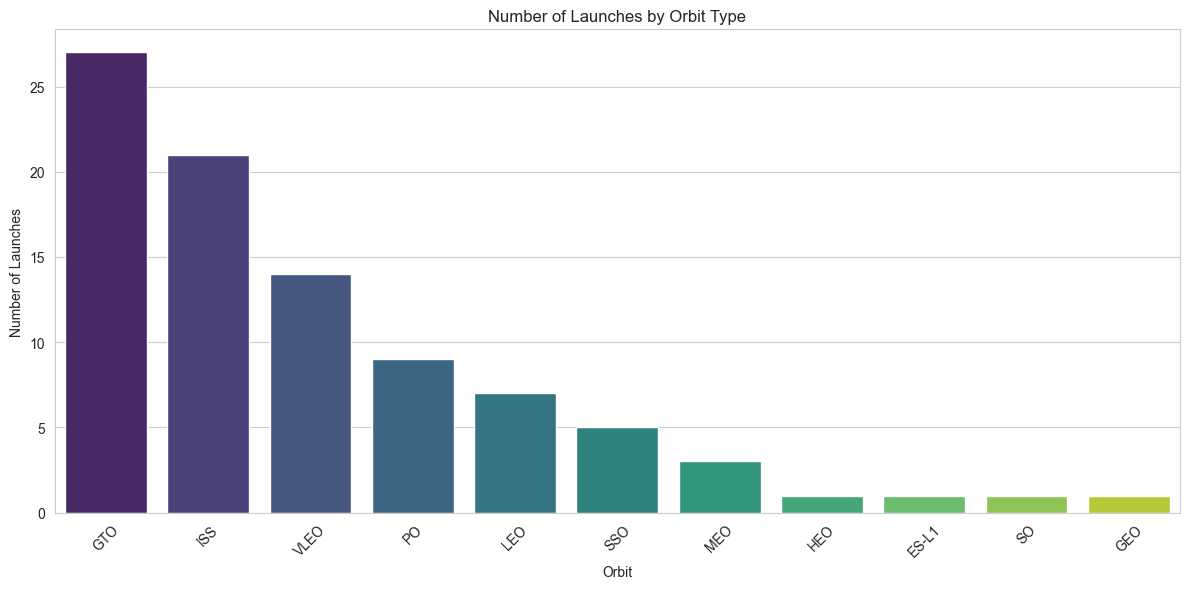

In [41]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=orbit_count.index,
    y=orbit_count.values,
    hue=orbit_count.index,  # explicitly assign hue
    palette=sns.color_palette('viridis', n_colors=len(orbit_count)),
    dodge=False,            # keeps bars from splitting due to hue
    legend=False            # we don’t need the redundant legend
)
plt.title('Number of Launches by Orbit Type')
plt.xlabel('Orbit')
plt.ylabel('Number of Launches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analyzing Landing Outcomes

The `Outcome` column describes the landing result of each mission, combining success status (`True` or `False`) with the landing method or location:

- **RTLS**: Return to Launch Site (ground landing)
- **ASDS**: Autonomous Spaceport Drone Ship (drone ship landing)
- **Ocean**: Controlled descent into the ocean
- **None**: No landing attempt or complete failure

We first examine how frequently each landing outcome occurs, then define a set of "bad outcomes" representing failed or missing landings. This will later help us generate a binary success/failure label for modeling.


In [42]:
# Count each unique landing outcome
landing_outcomes = data_falcon9['Outcome'].value_counts()
print(landing_outcomes)

# Print index and outcome type
for i, outcome in enumerate(landing_outcomes.keys()):
    print(i, outcome)

# Define the bad outcomes for filtering/labeling
bad_outcomes = set(landing_outcomes.keys()[[1, 3, 5, 6, 7]])
bad_outcomes


Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64
0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

### Creating a Binary Landing Success Label

To prepare for classification modeling, we simplify the `Outcome` column into a binary variable called `Class`:

- **1** → The first stage booster landed successfully
- **0** → The booster either failed to land or no landing was attempted

This transformation allows us to use supervised learning techniques to predict launch success.


In [44]:
# Create a binary landing outcome label: 1 for success, 0 for failure
landing_class = [1 if outcome not in bad_outcomes else 0 for outcome in data_falcon9['Outcome']]

# Assign to new column 'Class' using .loc to avoid chained assignment warning
data_falcon9.loc[:, 'Class'] = landing_class

# Preview the first few rows with the new label
data_falcon9[['Outcome', 'Class']].head(8)


,Outcome,Class
4,None None,0
5,None None,0
6,None None,0
7,False Ocean,0
8,None None,0
9,None None,0
10,True Ocean,1
11,True Ocean,1


### Overall Success Rate

To get a quick sense of how often SpaceX missions successfully land, we calculate the average of the `Class` column. Since 1 represents success, this directly reflects the overall success rate.


In [45]:
data_falcon9["Class"].mean()


np.float64(0.6666666666666666)

**Insight:**  
The overall success rate for Falcon 9 landings is approximately **66.67%**, indicating that about two-thirds of the launches resulted in successful first stage recoveries. This metric highlights SpaceX's rapid advancements in reusable rocket technology over time.


### Launch Site Success Rates

Some launch sites may have higher success rates due to infrastructure, landing conditions, or mission complexity. The following function calculates the success rate for any given launch site:


In [47]:
def calc_launch_success(dataframe, launch_site):
    site_data = dataframe[dataframe['LaunchSite'] == launch_site]
    total_launches = len(site_data)
    successful_launches = site_data['Class'].sum()
    success_rate = (successful_launches / total_launches) * 100
    return success_rate

# Example usage
launch_site = 'CCSFS SLC 40'
success_rate = calc_launch_success(data_falcon9, launch_site)
print(f"Success rate for {launch_site}: {success_rate:.2f}%")


Success rate for CCSFS SLC 40: 60.00%


Exporting the cleaned dataset for future use or standalone modeling.


In [48]:
# Optional: Save cleaned dataset
data_falcon9.to_csv('falcon9_launch_data_cleaned.csv', index=False)


## 4. Feature Engineering & Exploratory Data Analysis

In this section, we begin preparing the cleaned Falcon 9 launch dataset for machine learning by performing:

- **Exploratory Data Analysis (EDA)**: Identify patterns, relationships, and trends using visualizations
- **Feature Engineering**: Extract meaningful features from the dataset that may help predict landing success

We'll use the Python libraries `pandas`, `matplotlib`, and `seaborn` to conduct this analysis.


In [49]:
df = data_falcon9.copy()


### Flight Number vs. Payload Mass by Outcome

We explore how launch experience (represented by `FlightNumber`) and payload size (`PayloadMass`) relate to landing success.

Each point represents a launch. The color (hue) indicates whether the launch was successful (`Class = 1`) or not (`Class = 0`).


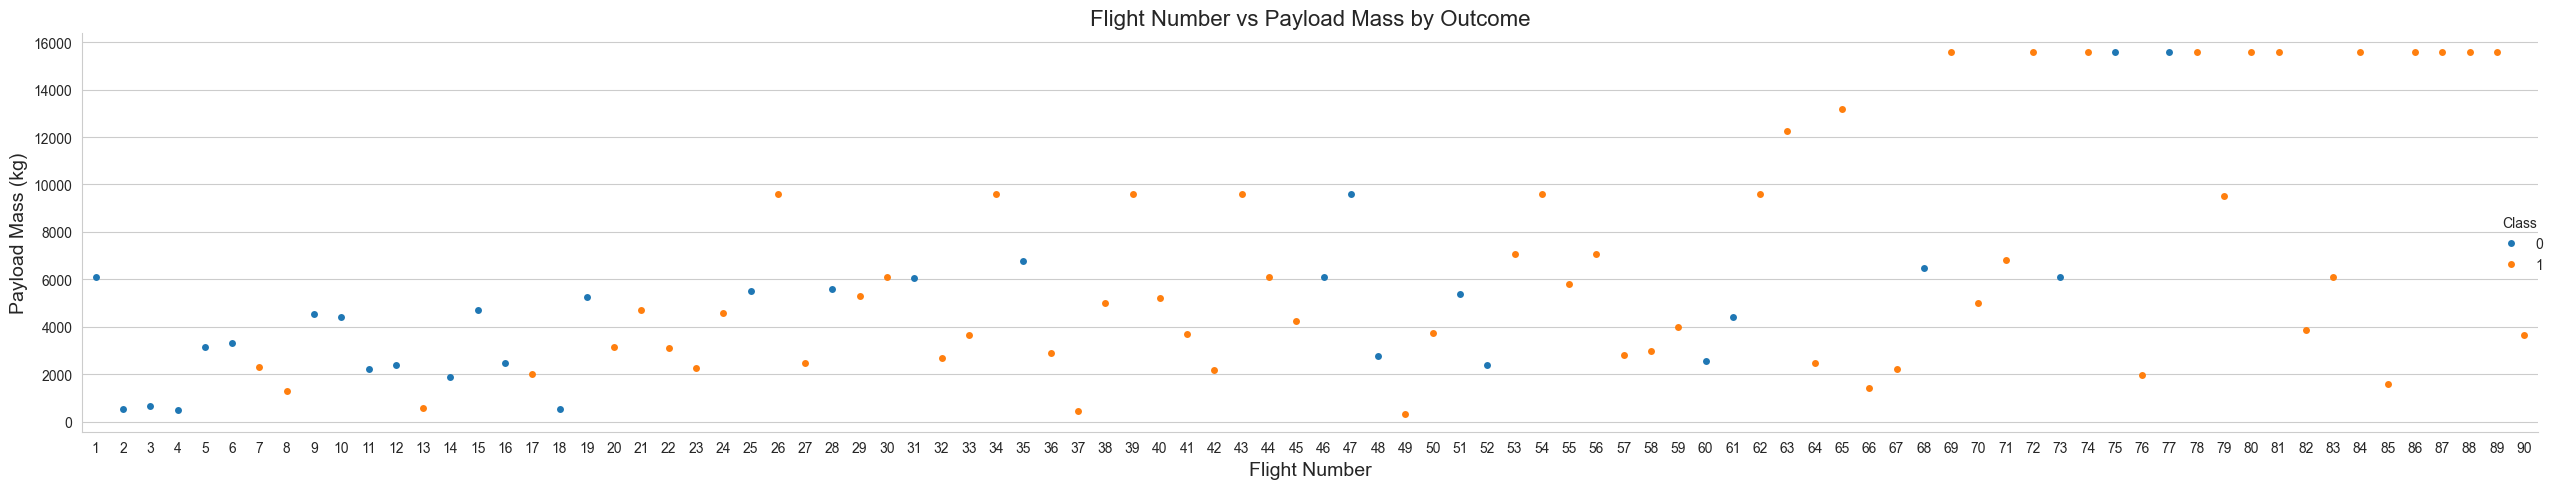

In [50]:
sns.catplot(
    y="PayloadMass",
    x="FlightNumber",
    hue="Class",
    data=df,
    aspect=5
)
plt.xlabel("Flight Number", fontsize=14)
plt.ylabel("Payload Mass (kg)", fontsize=14)
plt.title("Flight Number vs Payload Mass by Outcome", fontsize=16)
plt.tight_layout()
plt.show()


**Insight:**  
- We observe a general upward trend in success rates as `FlightNumber` increases, suggesting SpaceX improved their landing systems over time.  
- Even at higher payload masses, successful landings become more frequent—indicating engineering maturity and better booster control.


### Flight Number vs Launch Site

Next, we explore how launch success varies across different launch sites over time. Each dot represents a specific Falcon 9 launch attempt, with color representing whether the first stage landed successfully.

This chart helps us understand whether some launch sites have historically better success rates—or if SpaceX simply improved across the board over time.


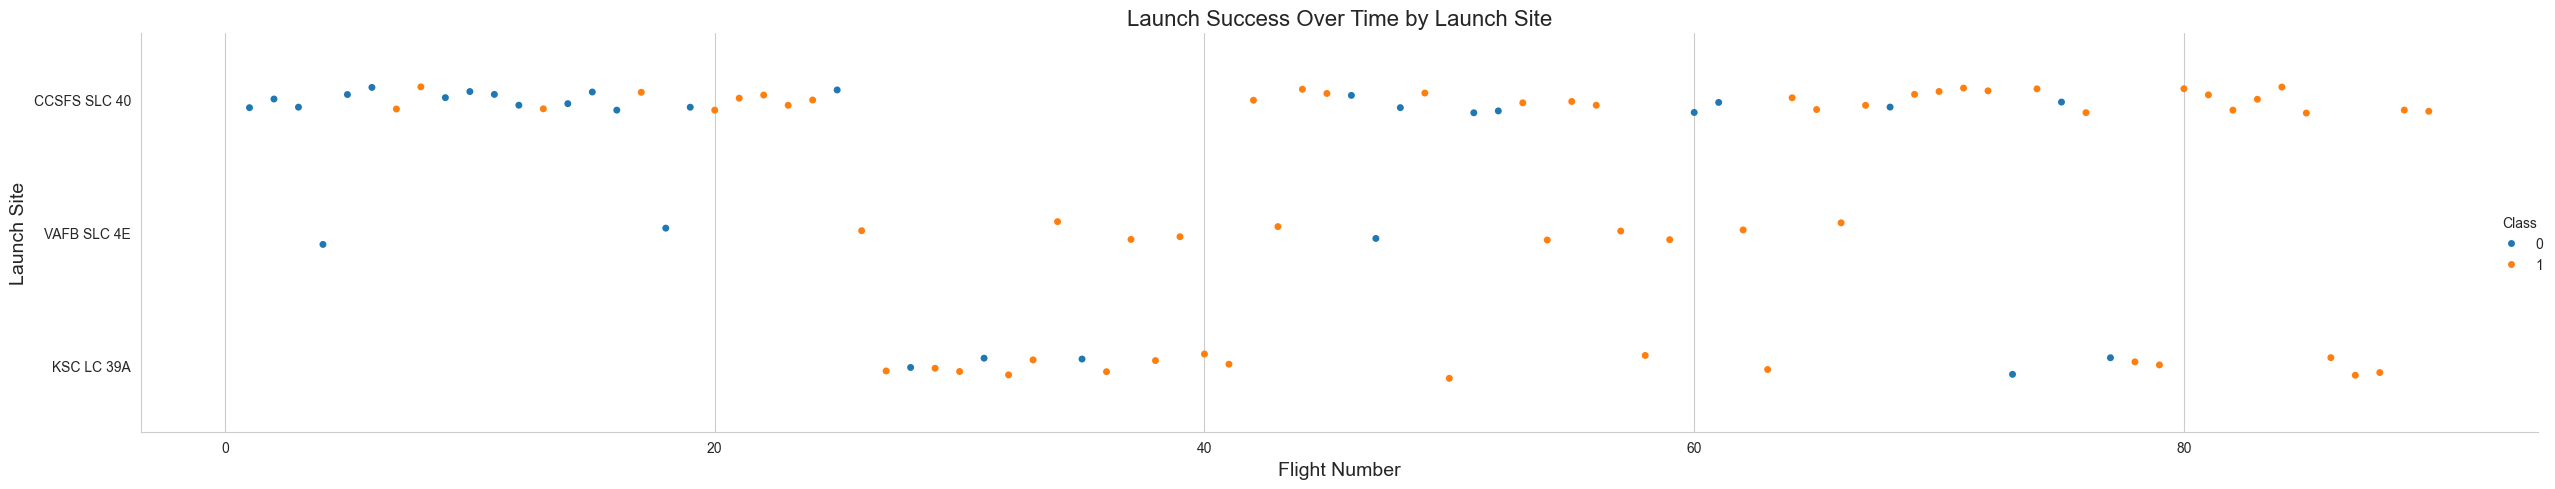

In [51]:
# Plot: Flight Number vs Launch Site with success hue
sns.catplot(
    y="LaunchSite",
    x="FlightNumber",
    hue="Class",
    data=df,
    aspect=5
)
plt.xlabel("Flight Number", fontsize=14)
plt.ylabel("Launch Site", fontsize=14)
plt.title("Launch Success Over Time by Launch Site", fontsize=16)
plt.tight_layout()
plt.show()


**Insight:**  

- **CCSFS SLC 40** shows a strong and consistent **improvement in launch success** over time, especially after early flights.
- **KSC LC 39A** had **early struggles with more failures**, but shows **better success in later launches**, indicating improved reliability.
- **VAFB SLC 4E** exhibits a more **scattered performance**, with no clear upward trend—success and failure appear interspersed throughout.
- Overall, there's a **visible trend of growing launch reliability**, particularly at high-frequency sites like CCSFS.



### Payload Mass vs Launch Site

We examine whether different launch sites are associated with varying payload sizes. This could indicate site-specific capabilities or operational preferences.

Each point represents a launch attempt, color-coded by its outcome.


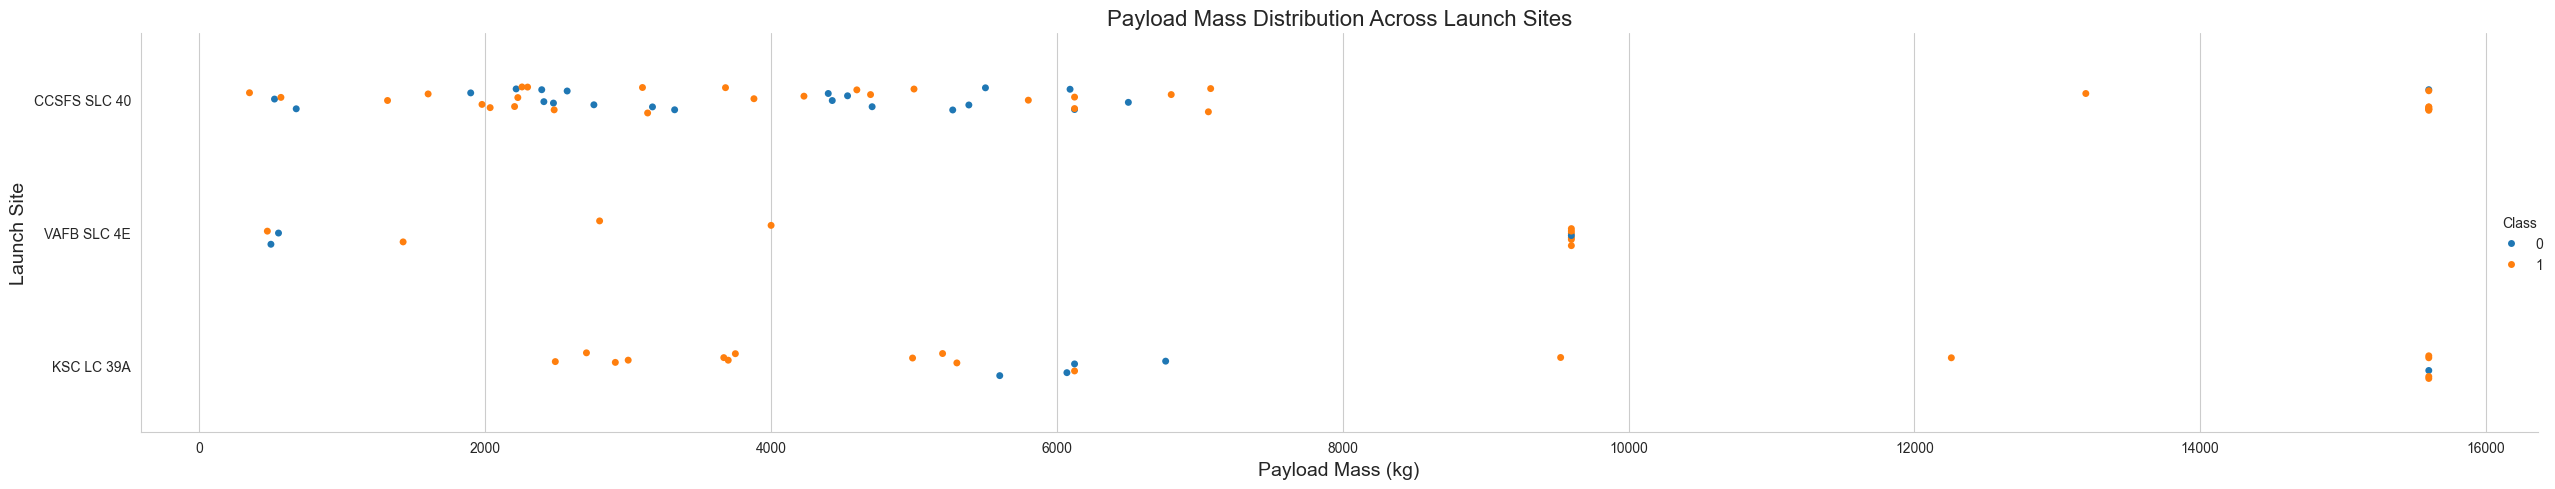

In [52]:
# Scatter plot: Payload Mass vs Launch Site, colored by success
sns.catplot(
    x="PayloadMass",
    y="LaunchSite",
    hue="Class",
    data=df,
    aspect=5
)
plt.ylabel("Launch Site", fontsize=14)
plt.xlabel("Payload Mass (kg)", fontsize=14)
plt.title("Payload Mass Distribution Across Launch Sites", fontsize=16)
plt.tight_layout()
plt.show()


**Insight:**  

- **CCSFS SLC 40** handled the widest range of payloads, with mass values spanning from near-zero to over 15,000 kg.
- **KSC LC 39A** focused on **heavier payloads**, mostly clustered above 3,000 kg, including the **heaviest payloads** overall.
- **VAFB SLC 4E** featured fewer launches with payloads primarily in the **mid to lower mass range**.
- Both successful (`Class 1`) and failed (`Class 0`) launches occurred across all sites and mass ranges, though **successes were more frequent overall**, especially at **higher payload masses**.



### Orbit Type vs Launch Success Rate

We examine whether success rates vary by orbit type. Different orbital destinations present different challenges—some may be riskier or require more complex launch trajectories.

Here, we calculate the average success rate (`Class` mean) for each orbit.


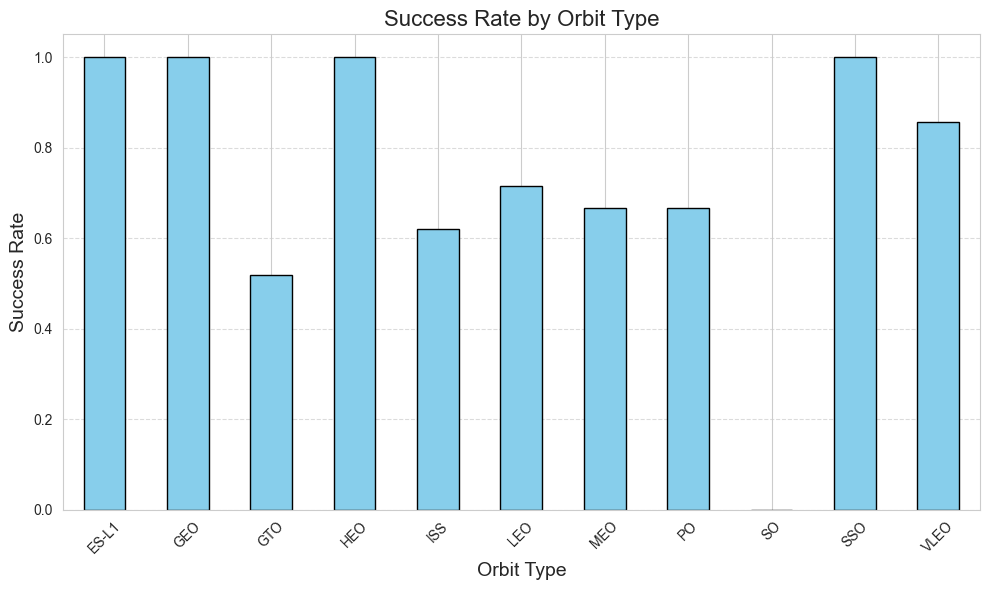

In [53]:
# Group by orbit and calculate success rate
success_rate = df.groupby('Orbit')['Class'].mean()

# Plot
plt.figure(figsize=(10,6))
success_rate.plot(kind='bar', color='skyblue', edgecolor='black')

# Styling
plt.title('Success Rate by Orbit Type', fontsize=16)
plt.xlabel('Orbit Type', fontsize=14)
plt.ylabel('Success Rate', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Insight:**  

- **Highest success rates** observed for **ES-L1, GEO, HEO, and SSO** missions (~100%), indicating strong reliability in these orbits.  
- **VLEO** also shows high success (~87%), reflecting consistent performance.  
- **LEO, MEO, and PO** have **moderate success rates (65–72%)**, possibly due to higher traffic or mission diversity.  
- **ISS** missions have a **lower success rate (~63%)**, likely reflecting increased complexity.  
- **GTO** stands out with the **lowest success rate (~52%)**, suggesting challenges in reaching or transitioning through this orbit.



### Flight Number vs Orbit Type

Now, we look at how launch experience (Flight Number) relates to success across different orbits. Some orbits may show improvement over time, while others remain consistently challenging.

Each dot is a launch attempt, color-coded by success.


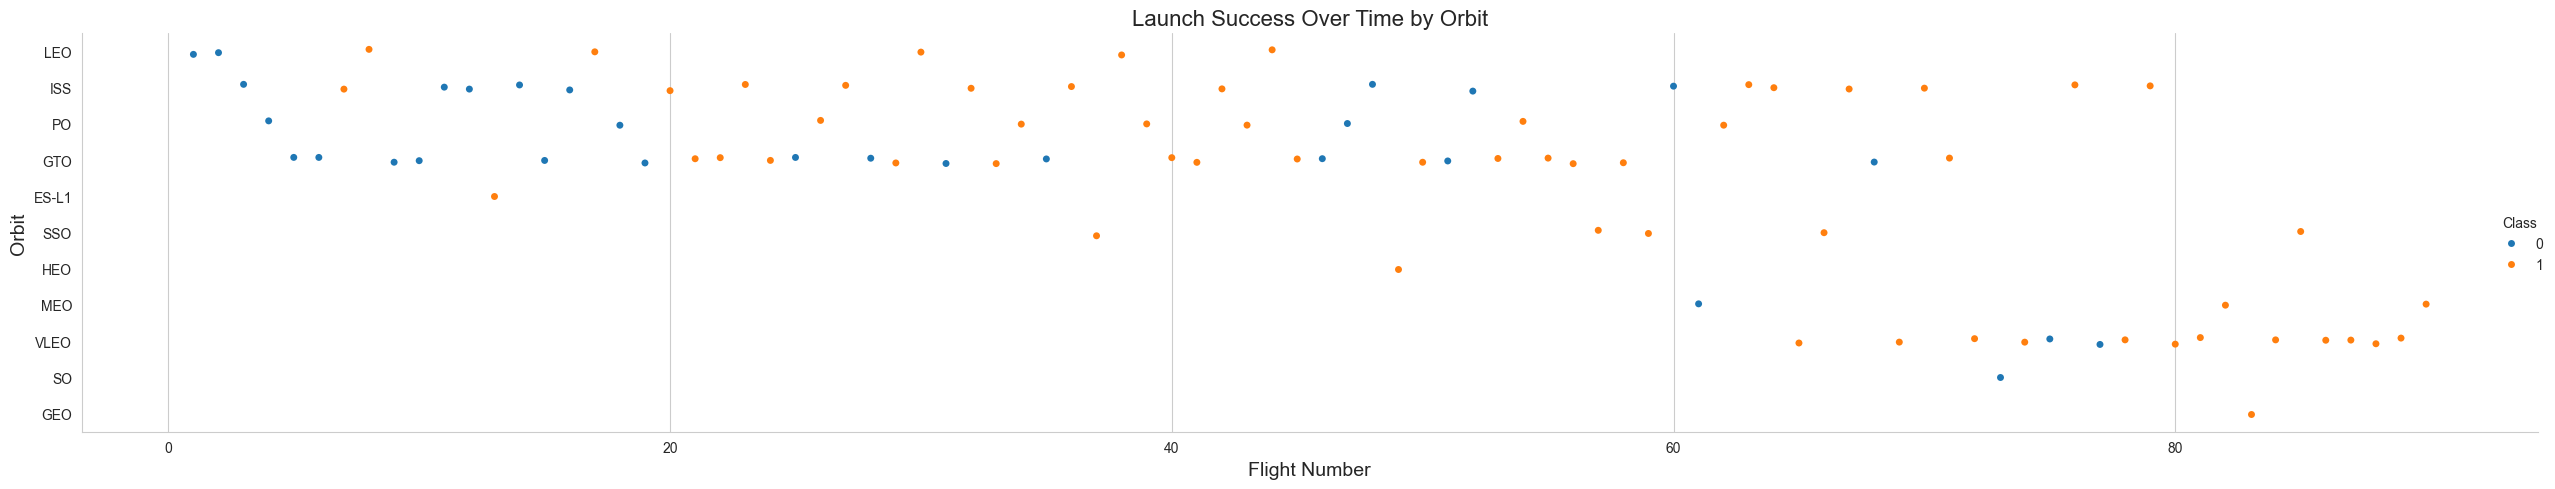

In [54]:
# Scatter: FlightNumber vs Orbit by Class
sns.catplot(
    y="Orbit",
    x="FlightNumber",
    hue="Class",
    data=df,
    aspect=5
)
plt.xlabel("Flight Number", fontsize=14)
plt.ylabel("Orbit", fontsize=14)
plt.title("Launch Success Over Time by Orbit", fontsize=16)
plt.tight_layout()
plt.show()


**Insight:**  

- **LEO and SSO** missions show consistently high success over time, indicating reliability in these orbit types.
- **GTO** launches had **a string of early failures**, followed by a gradual improvement in success rate.
- **ISS and PO** orbits show a **mixed performance**, with no strong trend toward improvement.
- **HEO, ES-L1, GEO, and SO** have relatively **few data points**, but exhibit mostly successful launches.
- **MEO and VLEO** show **increasing success in later flights**, possibly due to improved technology or operational experience.



### Payload Mass vs Orbit Type

This chart explores whether different orbit types are associated with different payload sizes, and how this correlates with landing success.

Each dot represents a Falcon 9 launch attempt, color-coded by success (`Class`).


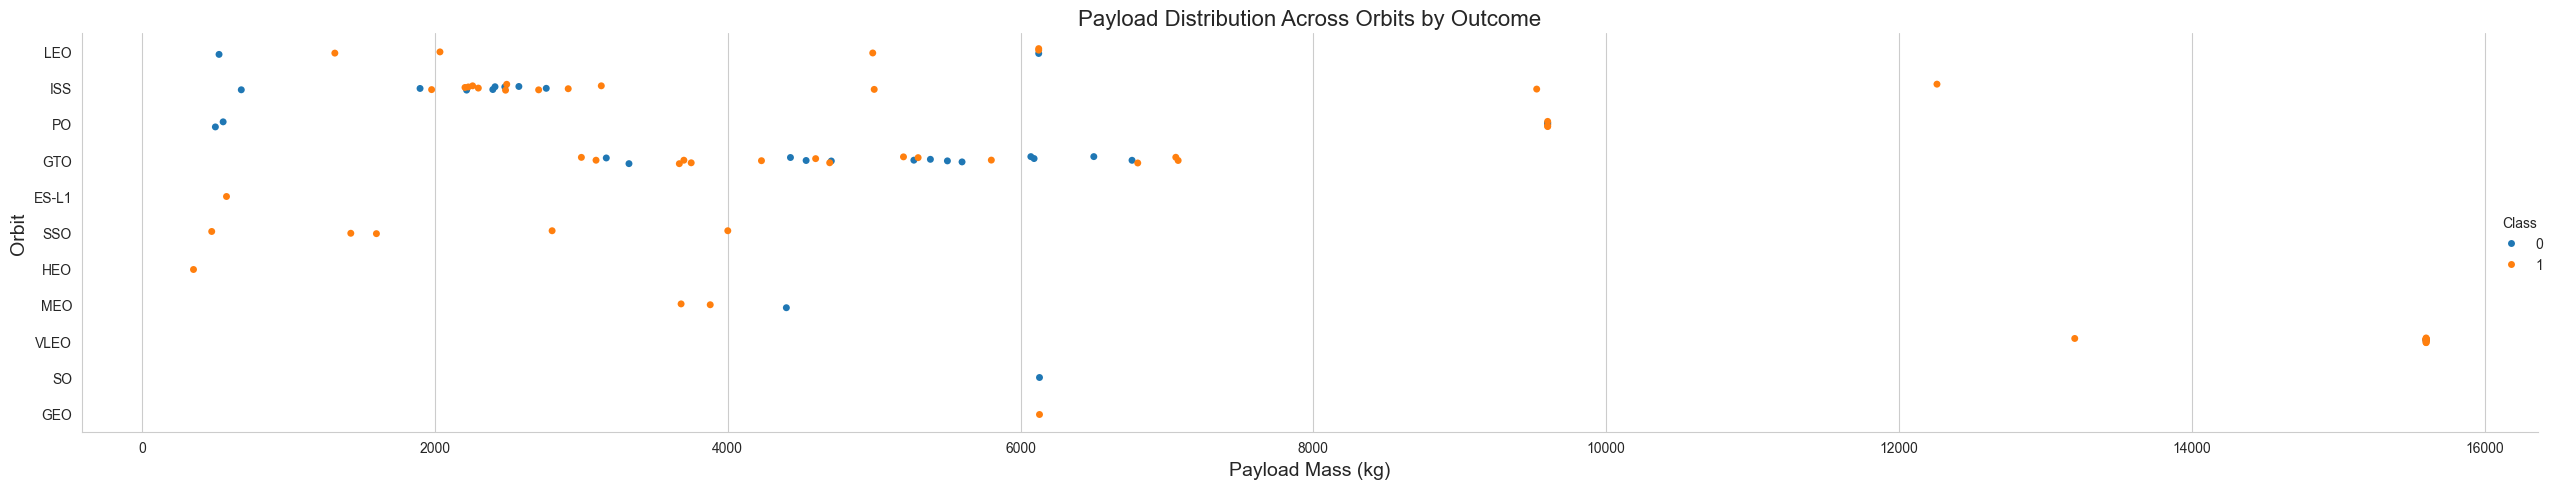

In [55]:
# Scatter: PayloadMass vs Orbit by Class
sns.catplot(
    y="Orbit",
    x="PayloadMass",
    hue="Class",
    data=df,
    aspect=5
)
plt.xlabel("Payload Mass (kg)", fontsize=14)
plt.ylabel("Orbit", fontsize=14)
plt.title("Payload Distribution Across Orbits by Outcome", fontsize=16)
plt.tight_layout()
plt.show()


**Insight:**  

- **Successful launches (Class 1)** span a wide payload mass range across most orbits, indicating adaptability of launch systems to various mission scales.
- **GTO** and **LEO** orbits exhibit a **broad spread of payload masses**, but **GTO has a higher density of failures (Class 0)**, especially in the 4000–6000 kg range.
- **SSO** and **VLEO** payloads are generally smaller (< 6000 kg) and show a high rate of success.
- **Heavy payloads (> 8000 kg)** are almost exclusively **successful** and associated with orbits like **HEO, GEO, and LEO**, suggesting improved reliability for large-mass missions.
- **SO and ES-L1** orbits show sparse but mostly successful launches.



### Yearly Launch Success Trend

We now visualize how SpaceX’s overall launch success rate has evolved over the years.  
By extracting the year from each launch date, we compute the average success rate per year.


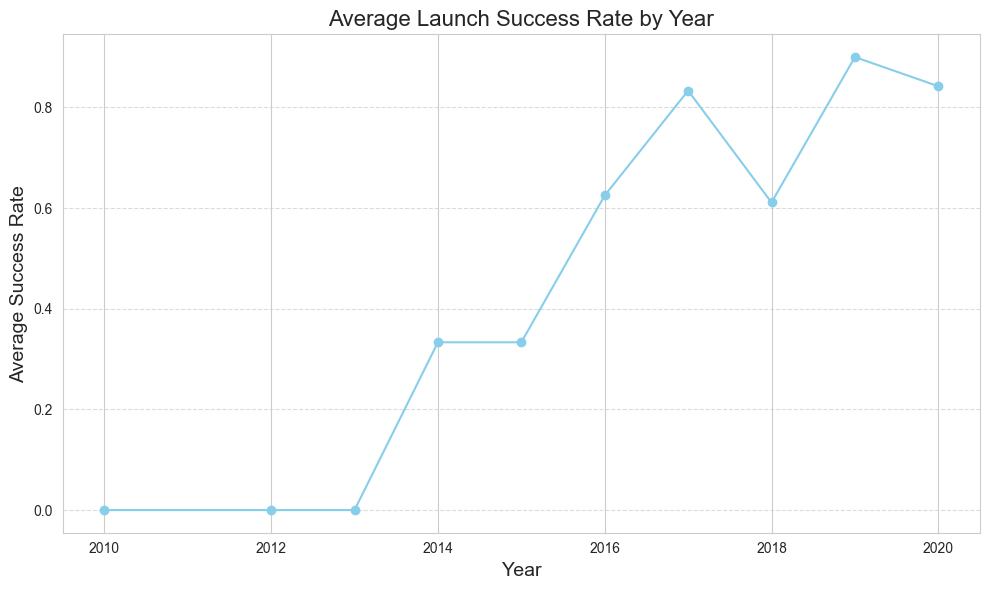

In [56]:
# Extract launch year from the Date column
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Calculate average success rate by year
yearly_success_rate = df.groupby('Year')['Class'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(yearly_success_rate.index, yearly_success_rate.values, marker='o', linestyle='-', color='skyblue')

# Styling
plt.title('Average Launch Success Rate by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Success Rate', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Insight:**  

- **2010–2013** saw **no successful launches**, highlighting early-stage challenges.
- A **turning point in 2014** marked the beginning of improved outcomes, with a 33% success rate.
- Steady improvements led to a **peak in 2019** with the **highest average success rate (~90%)**.
- Minor dips occurred in **2018 and 2020**, but the overall trend remains **strongly positive**, indicating significant growth in launch reliability over the decade.



## Feature Engineering

Having completed our exploratory data analysis, we now shift focus to preparing our dataset for predictive modeling.  
The goal of this stage is to transform raw and categorical features into a clean, machine-learning-ready format.

We begin by selecting relevant features that may influence launch success, such as booster flight history, payload weight, launch configuration, and landing details.

Before encoding, we also inspect the correlations between numeric variables and launch success (`Class`) to gain additional insights on feature strength.


In [60]:
# Selecting relevant features for modeling
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 
               'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 
               'ReusedCount', 'Serial']]
features.head()


,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


### Feature Correlation Heatmap
Before encoding categorical variables, we analyze how strongly each numeric feature correlates with launch success.

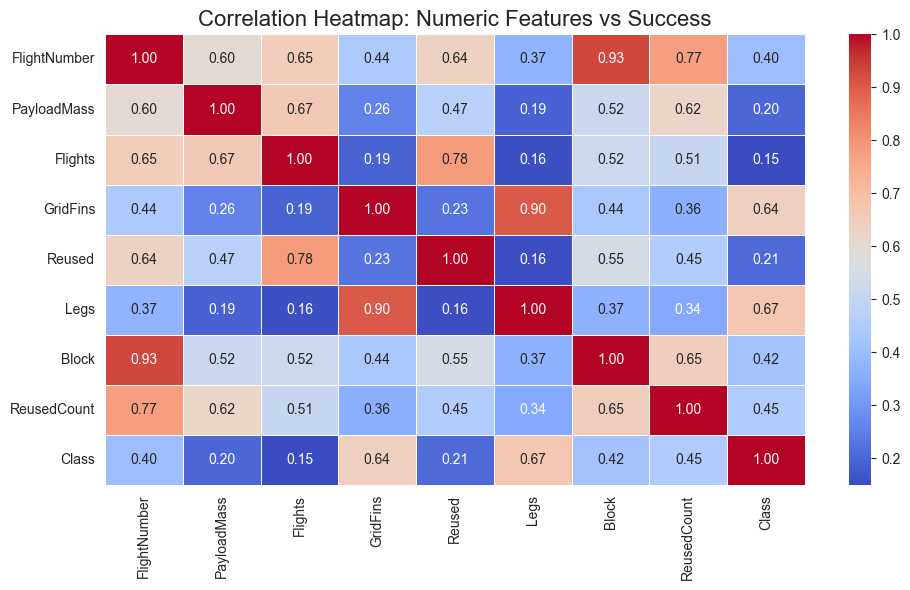

In [61]:
# Include 'Class' temporarily for correlation
correlation_df = df[['FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 
                     'Reused', 'Legs', 'Block', 'ReusedCount', 'Class']]

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Numeric Features vs Success', fontsize=16)
plt.tight_layout()
plt.show()


**Insight:**  

This heatmap allows us to visually compare the strength and direction of relationships between numerical features and the success class label.

- **GridFins**, **Legs**, and **Block** show the strongest positive correlation with launch success (`Class`), suggesting that upgraded Falcon 9 features contribute to reliability.
- **ReusedCount** and **FlightNumber** also have moderate positive correlations, indicating growing reliability over successive missions and booster reusability.
- Surprisingly, **PayloadMass** and **Flights** have **weak correlation** with success, meaning heavier or more frequent payloads don't necessarily impact outcome.
- Most features are positively correlated with each other, especially:
  - `Block` ↔ `FlightNumber` (0.93)
  - `Legs` ↔ `GridFins` (0.90)
  - `Reused` ↔ `Flights` (0.78)

This heatmap highlights which engineered features may be most useful for predictive modeling in the next section.



### One-Hot Encode Categorical Features

Machine learning models require all inputs to be numerical. We use one-hot encoding to convert categorical columns into numeric binary flags.

In [62]:
# One-hot encoding the specified columns
features_one_hot = pd.get_dummies(features, columns=["Orbit", "LaunchSite", "LandingPad", "Serial"])

# Display result
features_one_hot.head()


,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,2,525.000000,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,3,677.000000,1,False,False,False,1.0,0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,4,500.000000,1,False,False,False,1.0,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,5,3170.000000,1,False,False,False,1.0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### Convert Data Types to Float64
To ensure compatibility with most machine learning models, we cast all features to a uniform numeric type (float64).

In [63]:
# Cast the entire DataFrame to float64
features_one_hot = features_one_hot.astype('float64')

# Confirm result
features_one_hot.head()


,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



## 5. Machine Learning: Predicting Falcon 9 First Stage Landing Success

Now that we’ve cleaned, explored, and engineered the data, it’s time to build predictive models that determine whether a Falcon 9 rocket's first stage will successfully land. This task falls under **binary classification**, where:

- `1` represents a **successful landing**
- `0` represents a **failed landing**

### Goals for This Section:
- Prepare the feature set and target variable
- Split the data into training and testing sets
- Normalize features for better model performance
- Train and evaluate multiple classification algorithms:
  - Logistic Regression
  - Decision Tree
  - Support Vector Machine (SVM)
  - K-Nearest Neighbors (KNN)
- Compare their performance and identify the best-performing model

This stage simulates how predictive analytics can help stakeholders estimate mission success probabilities based on rocket configurations and launch metadata.



This function plots the confusion matrix for evaluation

In [64]:
def plot_confusion_matrix(y_true, y_pred):
    """Visualize confusion matrix for classification results."""
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Land', 'Landed'], yticklabels=['Did Not Land', 'Landed'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


### Preparing Target and Feature Data

To begin the modeling process, we extract the target variable `Class` from the dataset, which indicates whether a Falcon 9 launch was successful (`1`) or not (`0`). This binary label will be used as the dependent variable for supervised learning classification tasks.


In [65]:
# Create the target variable Y from the 'Class' column
Y = pd.Series(df['Class'].to_numpy())


### Standardizing the Feature Set

Machine learning models often perform better when input features are on the same scale. Here, we apply `StandardScaler` from `sklearn.preprocessing` to transform all features in `X` to have zero mean and unit variance. This helps ensure that no single feature dominates due to differences in magnitude.


In [68]:

# Standardize the feature data
transform = preprocessing.StandardScaler()
X = pd.DataFrame(transform.fit_transform(features_one_hot), columns=features_one_hot.columns)


### Splitting Data for Training and Evaluation

We split the dataset into training and test sets using an 80/20 ratio. The training set will be used to train and tune models, while the test set provides an unbiased evaluation of their performance. We also fix the random seed for reproducibility of results.


In [69]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Check the shape of test labels
Y_test.shape

(18,)

### Logistic Regression with Hyperparameter Tuning

We begin model development with Logistic Regression, a commonly used algorithm for binary classification. To find the optimal combination of hyperparameters, we perform a grid search using cross-validation.

We tune the regularization strength (`C`) and use the L2 penalty (`ridge` regularization) with the `'lbfgs'` solver, which is efficient for smaller datasets.

We apply `GridSearchCV` with 10-fold cross-validation to identify the combination that yields the best performance.


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
parameters = {"C": [0.01, 0.1, 1], "penalty": ["l2"], "solver": ["lbfgs"]}  # l2 = Ridge regularization

# Create logistic regression model
lr = LogisticRegression()

# Create GridSearchCV object
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)

# Fit the model to the training data
logreg_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [71]:
# Output best parameters and best cross-validation score
print("Tuned hyperparameters (best parameters):", logreg_cv.best_params_)
print("Cross-validated accuracy:", logreg_cv.best_score_)


Tuned hyperparameters (best parameters): {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-validated accuracy: 0.8214285714285714


### Evaluating Logistic Regression on Test Data

After training and hyperparameter tuning, we evaluate the model on unseen test data. The `.score()` method gives us the classification accuracy.

To better understand how the model is performing, we also visualize the confusion matrix. This helps us interpret not just how many predictions were correct, but also the types of errors made (false positives, false negatives, etc.).


In [72]:
# Calculate accuracy on the test data
accuracy = logreg_cv.score(X_test, Y_test)

# Print the accuracy
print(f"Accuracy on the test data: {accuracy:.2f}")


Accuracy on the test data: 0.83


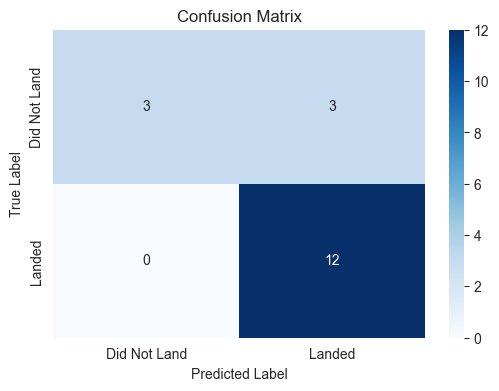

In [73]:
# Generate predictions and plot confusion matrix
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)


**Interpretation:**

- **True Positives (12)**: The model correctly predicted 12 successful landings.
- **True Negatives (3)**: It correctly identified 3 cases where the rocket did not land.  
- **False Positives (3)**: The model predicted a landing, but the rocket actually failed to land — indicating some over-prediction of success.  
- **False Negatives (0)**: No actual landings were missed by the model — a strong sign that it's effectively capturing true positives.

This suggests the model performs reasonably well, but tends to over-predict successful landings (false positives).


### Support Vector Machine (SVM) Model and Hyperparameter Tuning

We now train a Support Vector Machine (SVM) model and use GridSearchCV to find the best combination of kernel, regularization strength `C`, and kernel coefficient `gamma`. A variety of kernel functions (`linear`, `rbf`, `poly`, `sigmoid`) are tested using a 10-fold cross-validation strategy.


In [74]:
# Define hyperparameter grid
parameters = {
    'kernel': ('linear', 'rbf', 'poly', 'sigmoid'),
    'C': np.logspace(-3, 3, 5),
    'gamma': np.logspace(-3, 3, 5)
}

# Instantiate SVM model
svm = SVC()

# Create GridSearchCV with cross-validation
svm_cv = GridSearchCV(estimator=svm, param_grid=parameters, cv=10)

# Fit on training data
svm_cv.fit(X_train, Y_train)

# Output the best parameters and best cross-validation score
print("Tuned hyperparameters (best parameters):", svm_cv.best_params_)
print("Best cross-validation accuracy:", svm_cv.best_score_)


Tuned hyperparameters (best parameters): {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
Best cross-validation accuracy: 0.8482142857142858


In [75]:
# Retrieve and display best-performing kernel
best_kernel = svm_cv.best_params_['kernel']
print(f"The kernel with the best result on the validation dataset is: {best_kernel}")


The kernel with the best result on the validation dataset is: sigmoid


### Evaluating SVM on Test Data

We now evaluate the trained SVM model on the held-out test set. This gives us an estimate of how the model generalizes to unseen data.


In [76]:
# Evaluate accuracy on test data
svm_accuracy = svm_cv.score(X_test, Y_test)
print(f"Accuracy of the SVM on the test data: {svm_accuracy:.2f}")


Accuracy of the SVM on the test data: 0.83


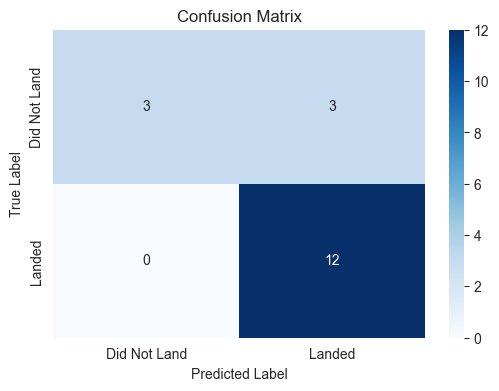

In [77]:
# Generate predictions and visualize the confusion matrix
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)


**Insight:**

- **True Positives (12)**: The SVM correctly predicted 12 successful landings. 
- **True Negatives (3)**: It also correctly predicted 3 failed landings.  
- **False Positives (3)**: The model predicted a landing where one did not occur — a sign of **over-prediction** of success.  
- **False Negatives (0)**: The SVM missed no actual landings — strong recall for the positive class.

This suggests the SVM model performs reasonably well, with solid accuracy and no false negatives, but shows a tendency to **over-predict successful landings** (false positives).



### Decision Tree Model and Hyperparameter Tuning

We now train a Decision Tree Classifier and use GridSearchCV to optimize multiple parameters including:

- **criterion**: the function to measure the quality of a split (`gini` or `entropy`)
- **splitter**: the strategy used to choose the split (`best` or `random`)
- **max_depth**: the maximum depth of the tree
- **max_features**: the number of features to consider when looking for the best split
- **min_samples_leaf**: the minimum number of samples required to be at a leaf node
- **min_samples_split**: the minimum number of samples required to split an internal node

This wide hyperparameter sweep is intended to find the most generalizable decision tree structure.


In [79]:
# Define hyperparameter grid for decision tree
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2 * n for n in range(1, 10)],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Instantiate the Decision Tree classifier
tree = DecisionTreeClassifier()

# Set up GridSearchCV with cross-validation
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=10)

# Fit the model to the training data
tree_cv.fit(X_train, Y_train)

# Output the best hyperparameters and best score
print("Tuned hyperparameters (best parameters):", tree_cv.best_params_)
print("Best cross-validation accuracy:", tree_cv.best_score_)


Tuned hyperparameters (best parameters): {'criterion': 'gini', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation accuracy: 0.8857142857142858


### Evaluating Decision Tree on Test Data

Now we evaluate the Decision Tree model on the test set to check how well it performs on unseen data.


In [80]:
# Compute accuracy on test data
tree_accuracy = tree_cv.score(X_test, Y_test)
print(f"Accuracy of the Decision Tree on the test data: {tree_accuracy:.2f}")


Accuracy of the Decision Tree on the test data: 0.78


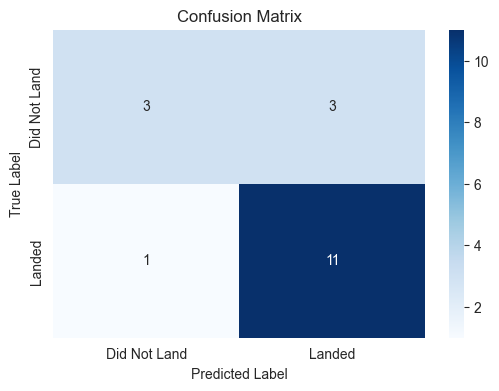

In [81]:
# Generate predictions and visualize the confusion matrix
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)


**Insight:**

- **True Positives (11)**: The model correctly predicted 11 successful landings.  
- **True Negatives (3)**: It correctly identified 3 failed landings.  
- **False Positives (3)**: Predicted a landing when it did not occur — some **over-prediction** remains.  
- **False Negatives (1)**: One actual landing was missed — a slight drop in **recall** compared to previous models.

This suggests that while the decision tree performs similarly to Logistic Regression and SVM in terms of overall accuracy, it **misses one actual landing** and continues the trend of **over-predicting successful outcomes**.

Decision Trees are flexible and interpretable models, but they are prone to overfitting unless regularized. Hyperparameter tuning via `GridSearchCV` helps mitigate this and ensures better generalization.


### K-Nearest Neighbors (KNN) Model and Hyperparameter Tuning

We now train a K-Nearest Neighbors classifier using GridSearchCV to optimize the following parameters:

- **n_neighbors**: number of neighbors to use
- **algorithm**: algorithm used to compute nearest neighbors
- **p**: power parameter for the Minkowski metric (`p=1` is Manhattan, `p=2` is Euclidean)

KNN is a simple yet powerful non-parametric method, and tuning the number of neighbors is key to balancing bias and variance.


In [82]:
# Define hyperparameter grid for KNN
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Instantiate the KNN classifier
knn = KNeighborsClassifier()

# Set up GridSearchCV with cross-validation
knn_cv = GridSearchCV(estimator=knn, param_grid=parameters, cv=10)

# Fit the model to the training data
knn_cv.fit(X_train, Y_train)

# Output the best hyperparameters and best score
print("Tuned hyperparameters (best parameters):", knn_cv.best_params_)
print("Best cross-validation accuracy:", knn_cv.best_score_)


Tuned hyperparameters (best parameters): {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
Best cross-validation accuracy: 0.8339285714285714


### Evaluating KNN on Test Data

Once trained, we evaluate the KNN model on the test set and visualize the confusion matrix to understand performance.


In [83]:
# Calculate accuracy on the test set
knn_accuracy = knn_cv.score(X_test, Y_test)
print(f"Accuracy of the KNN model on the test data: {knn_accuracy:.2f}")


Accuracy of the KNN model on the test data: 0.78


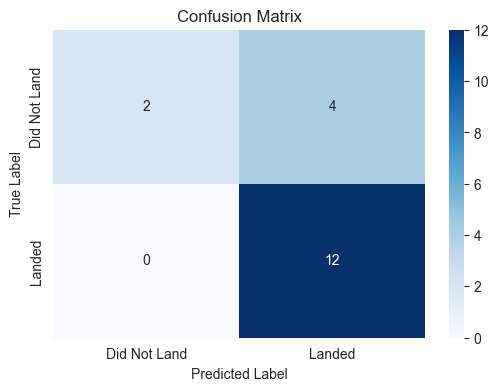

In [84]:
# Generate predictions and visualize the confusion matrix
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)


**Insight:**

- **True Positives (12)**: The model correctly predicted 12 successful landings.  
- **True Negatives (2)**: It correctly identified 2 failed landings.  
- **False Positives (4)**: Predicted a landing when it didn’t happen — the **highest false positive rate** among the models so far.  
- **False Negatives (0)**: No successful landings were missed — strong **recall** for the positive class.

The KNN model maintains perfect recall but suffers from a higher **false positive count**, indicating it is more likely to **misclassify failures as successes** compared to other models.

KNN performs well on smaller datasets but is sensitive to scaling and the choice of distance metric. It’s also computationally expensive on large datasets, but useful for comparison as a baseline.



### Model Comparison and Final Selection

After training and validating all four classification models — Logistic Regression, Support Vector Machine (SVM), Decision Tree, and K-Nearest Neighbors (KNN) — we compare their test accuracies to identify the best-performing algorithm.

Each model has been fine-tuned using `GridSearchCV` with 10-fold cross-validation to find the optimal set of hyperparameters.


In [85]:
# Calculate test set accuracy for all models
logreg_accuracy = logreg_cv.score(X_test, Y_test)
svm_accuracy = svm_cv.score(X_test, Y_test)
tree_accuracy = tree_cv.score(X_test, Y_test)
knn_accuracy = knn_cv.score(X_test, Y_test)

# Store model accuracies in a dictionary
model_accuracies = {
    'Logistic Regression': logreg_accuracy,
    'Support Vector Machine': svm_accuracy,
    'Decision Tree': tree_accuracy,
    'K Nearest Neighbors': knn_accuracy
}

# Identify the best performing model
best_model = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model]

# Display the results
print("Model Accuracies:")
for model, accuracy in model_accuracies.items():
    print(f"{model}: {accuracy:.4f}")
    
print(f"\nThe best performing model is {best_model} with an accuracy of {best_accuracy:.4f}.")


Model Accuracies:
Logistic Regression: 0.8333
Support Vector Machine: 0.8333
Decision Tree: 0.7778
K Nearest Neighbors: 0.7778

The best performing model is Logistic Regression with an accuracy of 0.8333.


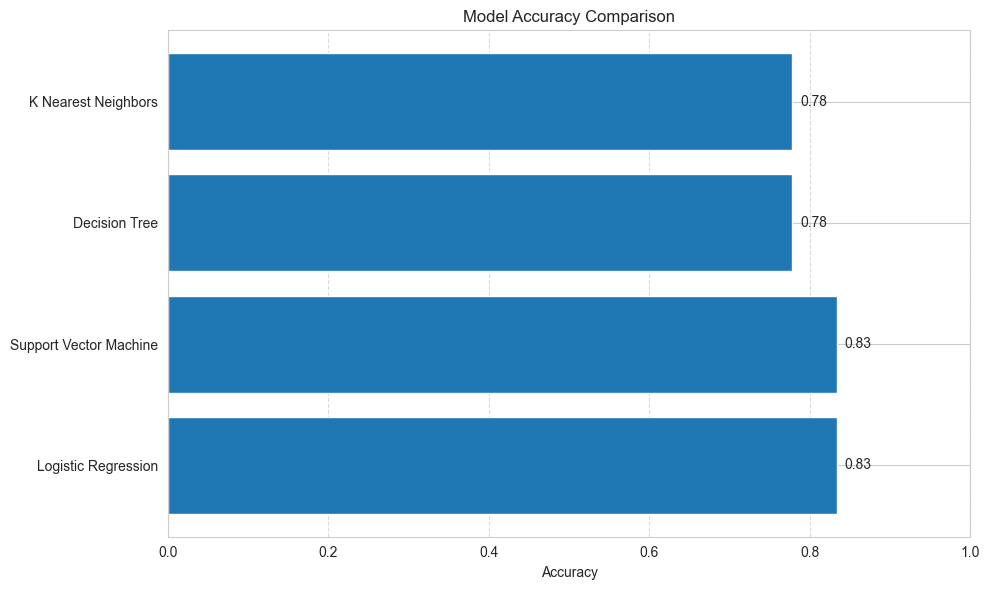

In [86]:

# Model accuracy values
model_accuracies = {
    'Logistic Regression': 0.8333,
    'Support Vector Machine': 0.8333,
    'Decision Tree': 0.7778,
    'K Nearest Neighbors': 0.7778
}

# Separate keys and values for plotting
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(models, accuracies)
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()


### Model Comparison and Selection

By comparing the final test accuracies, we gain a clear understanding of which model generalized best to unseen data. 

We trained and evaluated four classification algorithms to predict Falcon 9 first stage landing success:

- **Logistic Regression**
- **Support Vector Machine**
- **Decision Tree**
- **K Nearest Neighbors**

| Model                   | Accuracy |
|------------------------|----------|
| Logistic Regression     | 83.33%   |
| Support Vector Machine  | 83.33%   |
| Decision Tree           | 77.78%   |
| K Nearest Neighbors     | 77.78%   |

Both **Logistic Regression** and **SVM** emerged as top performers. Given its interpretability and simpler decision boundary, we choose **Logistic Regression** as the final model for deployment. This model can be shortlisted for deployment or further optimization, depending on the performance requirements of the application.





## 6. Results & Key Insights

This project set out to answer a high-stakes question:  
**What factors influence the successful landing of a Falcon 9 first stage?**

Our analysis revealed the following patterns:

### Launch Behavior & Trends

- **Operational learning led to higher success rates**  
  Launches with higher flight numbers were more likely to succeed—highlighting SpaceX’s iterative engineering maturity over time.

- **Mission orbit matters**  
  Launches to 'GEO', 'HEO', and 'SSO' orbits had the highest landing success rates. Conversely, 'GTO' missions showed mixed outcomes, suggesting a higher level of complexity or risk.

- **Heavy payloads weren’t a deal-breaker**  
  Successful landings occurred even with heavier payloads—particularly for ISS and Polar missions—dispelling the notion that mass alone predicts failure.

- **VAFB handled fewer and lighter launches**  
  The west coast site saw fewer missions, and rarely with payloads exceeding 10,000 kg, suggesting limited deployment for high-mass missions.

- **Year-over-year gains in reliability**  
  From 2013 to 2020, overall success rates climbed steadily—mirroring SpaceX’s real-world improvements in launch and recovery systems.



### Geospatial Insights (From Bonus Notebook)

- All four launch sites are located near coastlines, likely to minimize risks during recovery and maximize ocean access for boosters.

- Interactive Folium maps revealed spatial clusters in Florida and California, helping visualize proximity-based risk factors like highways and population centers.



### Feature Engineering Highlights

- **Enrichment from SpaceX API** gave us critical variables:
  - Booster version, payload orbit and mass
  - Launch site coordinates and names
  - Core-level recovery data

- **Missing data** in 'PayloadMass' was imputed with mean values, while 'LandingPad' nulls were preserved to reflect actual launch conditions.

- **Categorical features** (like orbit and booster serial) were one-hot encoded to enable machine learning.

- A new target column, **'Class'**, was created to classify successful landings ('1') vs. failed or no landings ('0').

- Overall landing success rate: **66.7%**.



### Machine Learning Evaluation

We trained and validated four classification models to predict landing success:

| Model                   | Validation Accuracy | Test Accuracy |
|------------------------|---------------------|----------------|
| Logistic Regression     | *0.82*              | **0.83**       |
| Support Vector Machine  | *0.84*              | **0.83**       |
| Decision Tree           | *0.88*              | **0.78**           |
| K Nearest Neighbors     | *0.83*              | **0.78**           |

> **Top Performer**: Logistic Regression offered the best balance of test accuracy and interpretability.

- **False positives were the most common error type**  
  Models frequently predicted a successful landing when one didn’t occur—an important insight for mission risk evaluation.

## 7. Conclusion & Future Improvements

This project demonstrated an end-to-end data science workflow applied to SpaceX Falcon 9 launch data. We began with raw API data, enriched it through feature engineering, and moved through structured exploratory analysis to predictive modeling.

From discovering patterns in payloads and orbits to training classification models, the notebook showcases the use of data to answer a high-stakes operational question:  
**What factors influence the successful landing of a Falcon 9 first stage?**

### Key Takeaways

- **Data Enrichment Was Crucial**: API-enriched features like 'BoosterVersion', 'Orbit', 'LandingPad', and 'ReusedCount' gave valuable context that raw launch logs alone could not provide.
  
- **Clear Success Patterns Emerged**:
  - Launches to 'GEO', 'HEO', and 'SSO' orbits had high success rates.
  - Success improved with higher flight numbers, indicating learning over time.
  - Heavier payloads were not necessarily a barrier to success.

- **Predictive Modeling Performed Well**:
  - The **Logistic Regression** model achieved the best test accuracy (83%), with SVM close behind.
  - Most misclassifications were **false positives**, underscoring the need for careful risk communication if used in operations.

### Future Enhancements

- **Add More Contextual Features**:
  - Include weather conditions, mission type (e.g., cargo vs crew), and time of day for deeper predictive power.

- **Model Optimization**:
  - Test ensemble methods (e.g., Random Forest, XGBoost) and fine-tune feature selection for robustness.

- **Deeper Geospatial Analysis**:
  - Expand the Folium-based proximity analysis to explore relationships with landing zone distances, water proximity, and nearby infrastructure.

- **Deployment Possibilities**:
  - Convert the final model into a lightweight Dash app or deploy it via Flask API for operational integration or stakeholder access.

This notebook establishes a solid foundation for aerospace predictive analytics and opens up multiple paths for further innovation—technical, visual, and strategic.


## 8. Recommendations

Based on the analytical insights and modeling outcomes from this project, the following data-informed actions are suggested:

- **Favor GEO and SSO Orbits for Reusability Missions**  
  Launches targeting GEO, HEO, ESL1 and SSO destinations demonstrated consistently high booster landing success rates. Prioritizing these orbits for missions relying on reusable boosters could optimize recovery outcomes and operational efficiency.

- **Enhance Predictive Inputs with Contextual Data**  
  Incorporating additional features like weather conditions, launch timing, and mission type (e.g., cargo vs. crewed) could sharpen model accuracy and provide richer operational foresight.

- **Monitor and Address False Positives in Predictions**  
  Confusion matrices revealed that misclassifications were predominantly false positives—cases where a landing was predicted to succeed but didn’t. This insight is critical for risk-sensitive mission planning and suggests a need for conservative interpretation in high-stakes launches.

- **Explore Booster Recovery Optimization for GTO Missions**  
  Missions to Geostationary Transfer Orbit (GTO) showed variable outcomes, particularly under heavier payloads. A closer investigation of recovery mechanics and trajectory design for GTO may yield opportunities for performance improvement.

- **Operationalize Predictive Modeling**  
  Deploy the trained model into a lightweight Dash app or backend API to support launch decision-making. This would offer real-time insight into landing likelihoods and reduce manual guesswork during launch planning.

These recommendations align with the core objective of this project—leveraging historical data to drive smarter, safer, and more efficient Falcon 9 launch operations.


## Extended Analysis & Interactive Components

This notebook is part of a larger analytical suite under **Mission Control: Predicting Falcon 9 First Stage Landings with Data Science**.

- **Geospatial Launch Insights**  
  An interactive Folium-based map that visualizes launch site locations and proximity to infrastructure like coastlines, highways, and cities.  
  → Open [Notebook: Geospatial Launch Insights](notebooks/mission_control_geospatial.ipynb)

- **Launch Performance Dashboard**  
  A browser-based Plotly Dash app for interactive exploration of launch success rates by site, payload mass, and booster version.  
  → Run [Script: Launch Performance Dashboard](app/mission_control_dashboard.py)



---

For dataset, environment setup, and additional project notes, see the [README](../README.md).


---

This project is part of a broader portfolio which showcases practical applications of data science across analytics, visualization, and machine learning. For more projects, visit [My GitHub Portfolio](https://github.com/J1111-dotcom).
